In [19]:
import tensorflow as tf
print(len(tf.config.list_physical_devices('GPU'))>0)

True


In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [21]:
folder_path = 'C:/Users/rsk13/Desktop/Om/DL/Functional API/archive/UTKFace'

In [24]:
age, gender, image_path = [], [], []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    image_path.append(file)

In [25]:
len(age), len(gender), len(image_path)

(23708, 23708, 23708)

### Creating a dataframe

In [26]:
df = pd.DataFrame({'Age':age, 'Gender':gender, 'Image':image_path})
df.head()

,Age,Gender,Image
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [29]:
df['Age'].value_counts()

Age
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Name: count, Length: 104, dtype: int64

In [30]:
df.shape

(23708, 3)

### Splitting Data to train and test

In [38]:
train_data = df.sample(frac=1, random_state=0).iloc[:20000]
test_data = df.sample(frac=1, random_state=0).iloc[20000:]

In [39]:
train_data.shape, test_data.shape

((20000, 3), (3708, 3))

### Data Augmentation

In [40]:
train = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,    
    rescale=1/255,
)

#test = ImageDataGenerator(rescale=1./255)

In [42]:
train_generator = train.flow_from_dataframe(train_data,
                                            directory=folder_path,
                                            x_col='Image',
                                            y_col=['Age','Gender'],
                                            target_size=(200,200),
                                            class_mode='multi_output')

test_generator = test.flow_from_dataframe(test_data,
                                            directory=folder_path,
                                            x_col='Image',
                                            y_col=['Age','Gender'],
                                            target_size=(200,200),
                                          class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


## Model Building

In [44]:
vgg = VGG16(include_top=False, input_shape=(200,200,3))

In [45]:
vgg.trainable = False

In [53]:
output = vgg.layers[-1].output

In [54]:
flatten = Flatten()(output)

Dense1 = Dense(512, activation='relu')(flatten) #Age
Dense2 = Dense(512, activation='relu')(flatten) #Gender

Dense3 = Dense(512, activation='relu')(Dense1) #Age
Dense4 = Dense(512, activation='relu')(Dense2) #Gender
 
output1 = Dense(1, activation='linear', name='Age')(Dense3) 
output2 = Dense(1, activation='sigmoid', name='Gender')(Dense4)

In [55]:
model = Model(inputs = vgg.input, outputs = [output1, output2])

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [58]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


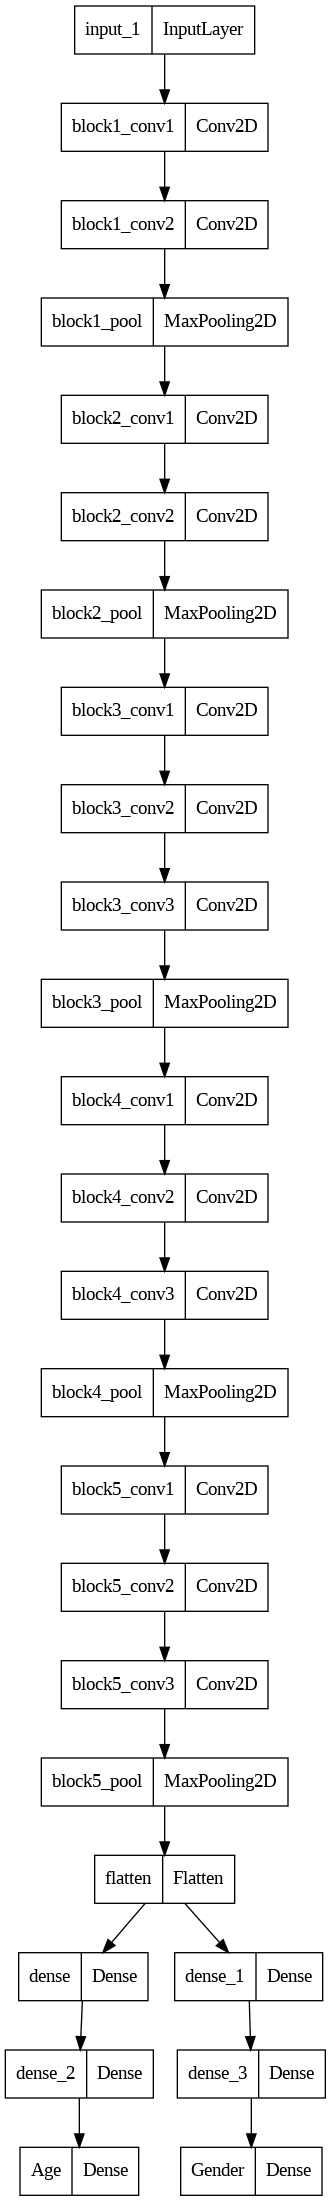

In [59]:
model.compile(optimizer='adam',loss={'Age':'mae','Gender':'binary_crossentropy'}, 
              metrics={'Age':'mae','Gender':'Accuracy'})

In [61]:
history = model.fit(train_generator, validation_data=test_generator, batch_size=32, epochs=10, callbacks=[es, mc])

Epoch 1/10
625/625 [==============================] - 470s 753ms/step - loss: 10.1837 - Age_loss: 9.7259 - Gender_loss: 0.4578 - Age_mae: 9.7259 - Gender_Accuracy: 0.7778 - val_loss: 9.5170 - val_Age_loss: 9.1554 - val_Gender_loss: 0.3616 - val_Age_mae: 9.1554 - val_Gender_Accuracy: 0.8336
Epoch 2/10
625/625 [==============================] - 449s 718ms/step - loss: 9.5634 - Age_loss: 9.1362 - Gender_loss: 0.4272 - Age_mae: 9.1362 - Gender_Accuracy: 0.7961 - val_loss: 8.5423 - val_Age_loss: 8.2157 - val_Gender_loss: 0.3265 - val_Age_mae: 8.2157 - val_Gender_Accuracy: 0.8533
Epoch 3/10
625/625 [==============================] - 466s 745ms/step - loss: 9.2551 - Age_loss: 8.8470 - Gender_loss: 0.4081 - Age_mae: 8.8470 - Gender_Accuracy: 0.8074 - val_loss: 8.6881 - val_Age_loss: 8.3623 - val_Gender_loss: 0.3258 - val_Age_mae: 8.3623 - val_Gender_Accuracy: 0.8552
Epoch 4/10
625/625 [==============================] - 610s 976ms/step - loss: 9.0169 - Age_loss: 8.6209 - Gender_loss: 0.3960 - A

In [68]:
history.history.keys()

dict_keys(['loss', 'Age_loss', 'Gender_loss', 'Age_mae', 'Gender_Accuracy', 'val_loss', 'val_Age_loss', 'val_Gender_loss', 'val_Age_mae', 'val_Gender_Accuracy'])

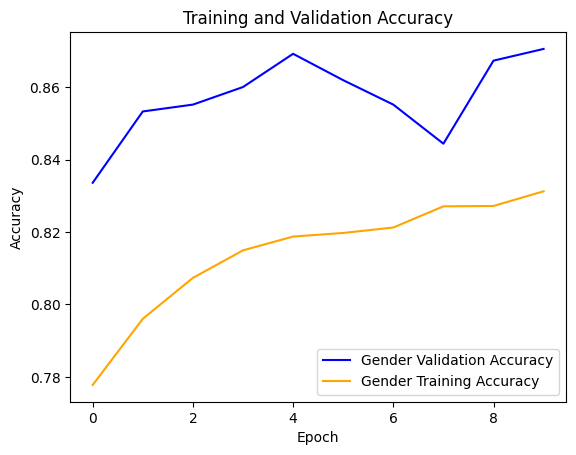

In [72]:
plt.plot(history.history['val_Gender_Accuracy'], color='blue', label='Gender Validation Accuracy')
plt.plot(history.history['Gender_Accuracy'], color='orange', label='Gender Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()

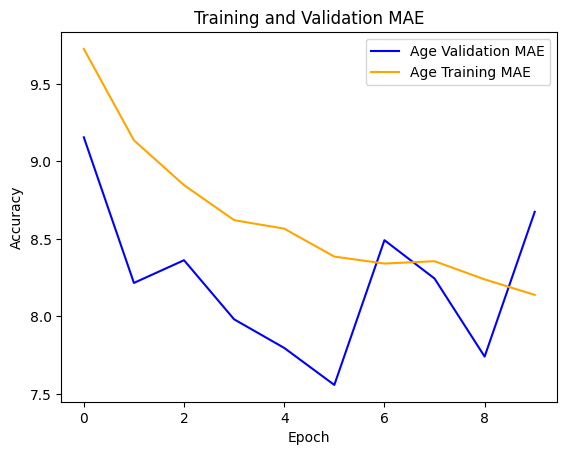

In [75]:
plt.plot(history.history['val_Age_mae'], color='blue', label='Age Validation MAE')
plt.plot(history.history['Age_mae'], color='orange', label='Age Training MAE')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation MAE')

plt.legend()

plt.show()